## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
from variaIa import baserate
from variaIa import stretchevol
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys, $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean, std et données totales

In [2]:
cons = ipw.Checkbox(
    value=False,
    description='Conservative')
display(cons)

Checkbox(value=False, description='Conservative')

In [3]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

#if cons.value:
surv = {'SNF':  d_snf.loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)],
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}
#else:
#    surv = {'SNF':  d_snf,
#            'SDSS': d[d['IDSURVEY'] == 1],
#            'PS1':  d[d['IDSURVEY'] == 15],
#            'SNLS': d[d['IDSURVEY'] == 4],
#            'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

with open('../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)

z_max['SNF'] = [10, 10]
z_max['HST'] = [10, 10]

dgmap = plt.cm.get_cmap('viridis')
colors = {'SNF': dgmap(0),
          'SDSS': dgmap(50),
          'PS1': dgmap(125),
          'SNLS': dgmap(200),
          'HST': dgmap(300)}

zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()

if cons.value:
    for survey in surveys[1:]:
        zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
        z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
        x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
        x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]

        zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < z_max['SNF'][0])
        z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
        x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
        x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]
        
        py = surv['SNF']['p(prompt)'].values[zmax_cuts['SNF']]
else:
    for survey in surveys[1:]:
        zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][-1])
        z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
        x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
        x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]

        zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < z_max['SNF'][-1])
        z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
        x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
        x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]
        
        py = surv['SNF']['p(prompt)'].values[zmax_cuts['SNF']]

names = []
#stretchs = [x1_zcuts['SNF'][i] for i in range(len(x1_zcuts['SNF']))]
stretchs = []
stretchs_err = []
redshifts = []
infor = list(surv['SNF']['p(prompt)'].values[zmax_cuts['SNF']])

for survey in surveys:
    names += [survey for i in range(len(z_zcuts[survey]))]
    #stretchs += [x1_zcuts[survey][i] for i in range(len(x1_zcuts[survey]))]
    stretchs += list(x1_zcuts[survey])
    stretchs_err += list(x1_err_zcuts[survey])
    redshifts += list(z_zcuts[survey])
    if survey != 'SNF':
        infor += list(z_zcuts[survey])

df = pd.DataFrame({'survey': names,
                   'stretchs': stretchs,
                   'stretchs_err': stretchs_err,
                   'redshifts': redshifts,
                   'infor': infor})

z_mean = np.mean(df.redshifts)
z_std = np.std(df.redshifts)
x1_mean = np.mean(df.stretchs)
x1_std =np.std(df.stretchs)

datax_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_zcuts['SNF'],
                             x1_zcuts['SDSS'])),
             x1_zcuts['PS1'])),
         x1_zcuts['SNLS'])),
     x1_zcuts['HST']))
                                                     
datax_err_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((x1_err_zcuts['SNF'],
                             x1_err_zcuts['SDSS'])),
             x1_err_zcuts['PS1'])),
         x1_err_zcuts['SNLS'])),
     x1_err_zcuts['HST']))
                                                     
dataz_all = np.concatenate(
    (np.concatenate(
        (np.concatenate(
            (np.concatenate((z_zcuts['SNF'],
                             z_zcuts['SDSS'])),
             z_zcuts['PS1'])),
         z_zcuts['SNLS'])),
     z_zcuts['HST']))

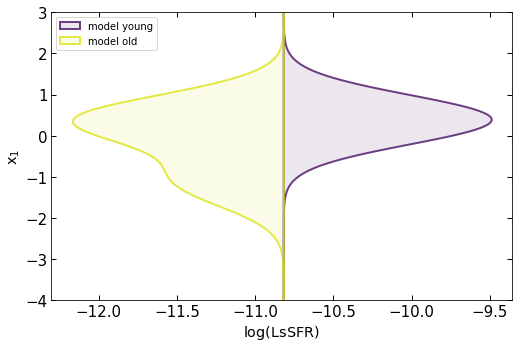

In [9]:
test = stretchevol.fitter()
test.set_pandas(df)
test.set_model('Evol3G2M2SSNF')
test.fit()

test.model.param

test.model.plotter()

## Minimisation des modèles à mettre dans le _pandas_

In [4]:
########################################### Assym PS1

assymPS1 = stretchevol.Evol1G1M2S()
assymPS1.set_data(z_zcuts['PS1'], x1_zcuts['PS1'], x1_err_zcuts['PS1'])

print('PS1')

assymPS1.minimize()
# assymPS1.traceur()

########################################### Assym PS1_full

assymPS1_full = stretchevol.Evol1G1M2S()
assymPS1_full.set_data(surv['PS1'].zCMB, surv['PS1'].x1, surv['PS1'].x1ERR)

print('PS1 full')

assymPS1_full.minimize()

########################################### Assym SDSS

assymSDSS = stretchevol.Evol1G1M2S()
assymSDSS.set_data(z_zcuts['SDSS'], x1_zcuts['SDSS'], x1_err_zcuts['SDSS'])

print('SDSS')

assymSDSS.minimize()

########################################### Assym SNLS

assymSNLS = stretchevol.Evol1G1M2S()
assymSNLS.set_data(z_zcuts['SNLS'], x1_zcuts['SNLS'], x1_err_zcuts['SNLS'])

print('SNLS')

assymSNLS.minimize()

PS1
PS1 full
SDSS
SNLS


## Modèle _base_ pour comparaison

{'aa': -0.05736408165218872,
 'mu_1': 0.4072077823779922,
 'sigma_1': 0.5497965906630451,
 'mu_2': -1.384008608940938,
 'sigma_2': 0.43891315006033}

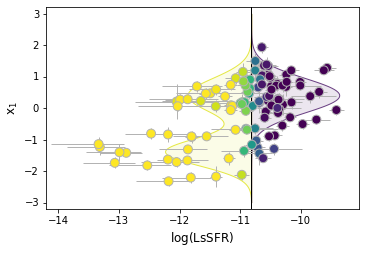

In [9]:
base = stretchevol.Evol3G2M2SSNF()
#base.set_pandas(df, py=True)

base.set_lssfr(surv['SNF']['salt2.X1'], surv['SNF']['salt2.X1.err'],
                  surv['SNF']['lssfr'], surv['SNF']['lssfr.err_down'], surv['SNF']['lssfr.err_up'],
                  surv['SNF']['p(prompt)'])

base.minimize()

fig = plt.figure(figsize=[7, 3.5])
ax = fig.add_axes([0.1, 0.12, 0.62, 0.8])

base.scatter(ax=ax, mod_lw=1, elw=1, lw=1,
                     facealpha=1, show_leg=False)

prop = dict(orientation='horizontal',
            histtype='step',
            fill=True,
            range=(-3, 3), bins=14,
            lw=1)

base.show_model(ax=ax, facealpha=0,
                        edgealpha=1, lw=1, zorder=8)

ax.set_xlim(-14.2, -9.05)
ax.set_ylim(-3.2, 3.2)

base.param

In [11]:
assymPS1.param

{'mu': 0.38216522997428914,
 'sigma_m': 1.008420809532303,
 'sigma_p': -0.5224444954297646}

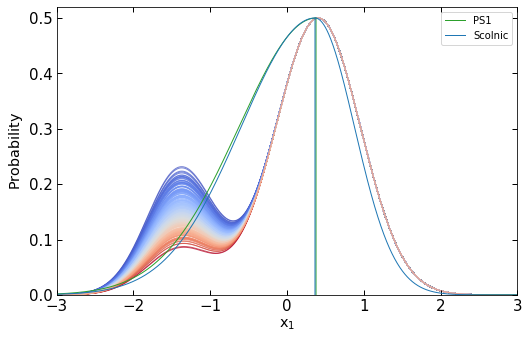

In [10]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

x_linspace = np.linspace(assymPS1.floor, assymPS1.ceil, 3000)
flag_up = x_linspace >= assymPS1.param['mu']

color_p = "C2"

ax.vline(assymPS1.param['mu'], 0, .499,
         color=color_p, alpha=.5, linewidth=2.0)

ax.plot(x_linspace[flag_up],
        (assymPS1.param['sigma_p']) * np.sqrt(np.pi/2) *
        assymPS1.gauss(x_linspace[flag_up],
                       np.zeros(len(x_linspace[flag_up])),
                       assymPS1.param['mu'],
                       assymPS1.param['sigma_p']),
        color=color_p, label='PS1',
        lw=1)
ax.plot(x_linspace[~flag_up],
        (assymPS1.param['sigma_m']) * np.sqrt(np.pi/2) *
        assymPS1.gauss(x_linspace[~flag_up],
                       np.zeros(len(x_linspace[~flag_up])),
                       assymPS1.param['mu'],
                       assymPS1.param['sigma_m']),
        color=color_p,
        lw=1)

mu_s = 0.365
sigma_m_s = 0.963
sigma_p_s = 0.514
flag_up_s = x_linspace >= mu_s

color_s = "C0"

ax.vline(mu_s, 0, .499,
         color=color_s, alpha=.5, linewidth=2.0)

ax.plot(x_linspace[flag_up_s],
        sigma_p_s*np.sqrt(np.pi/2)*
        assymPS1.gauss(x_linspace[flag_up_s],
                       np.zeros(len(x_linspace[flag_up_s])),
                       mu_s,
                       sigma_p_s),
        color=color_s, label='Scolnic',
        lw=1)

ax.plot(x_linspace[~flag_up_s],
        sigma_m_s*np.sqrt(np.pi/2)*
        assymPS1.gauss(x_linspace[~flag_up_s],
                       np.zeros(len(x_linspace[~flag_up_s])),
                       mu_s,
                       sigma_m_s),
        color=color_s,
        lw=1)

dgmap = plt.cm.get_cmap('coolwarm')
nb_base = len(surv['PS1'].zCMB)
c_linspace = 1-np.linspace(0, 1, len(surv['PS1'].zCMB))
i = 0

z_m, z_p = np.percentile(surv['PS1'].zCMB, [0,100])

for z in surv['PS1'].zCMB: #np.linspace(0.05, 1, nb_base)[:-1]:
    ax.plot(x_linspace,
            0.5/
            np.max(base.likelihood_tot(base.delta(z),
                                       x_linspace, np.zeros(len(x_linspace)),
                                       base.param['aa'],
                                       base.param['mu_1'], base.param['sigma_1'],
                                       base.param['mu_2'], base.param['sigma_2']))*
            base.likelihood_tot(base.delta(z),
                                x_linspace, np.zeros(len(x_linspace)),
                                base.param['aa'],
                                base.param['mu_1'], base.param['sigma_1'],
                                base.param['mu_2'], base.param['sigma_2']),
            color=dgmap((z-z_m)/(z_p-z_m)), alpha=.7,
            lw=1, zorder=1)
    i += 1

                                                      
ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)
                                                                      
ax.set_xlim([assymPS1.floor, assymPS1.ceil])
ax.set_ylim([0, .52])
                                                                      
ax.set_ylabel(r'$\mathrm{Probability}$', fontsize='x-large')
ax.set_xlabel(r'$\mathrm{x}_1$', fontsize='x-large')
                                                                      
ax.legend(ncol=1, loc='upper right')

fig.savefig('../../../Images/bbc_comp.pdf', bbox_inches='tight')

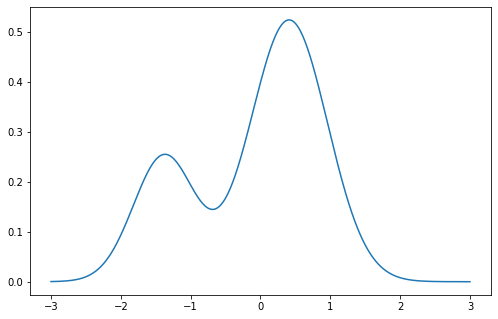

In [78]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

xx = np.linspace(-3, 3, 3000)

snf_a = 0.48
snf_mu_1 = 0.41
snf_sigma_1 = 0.55
snf_mu_2 = -1.38
snf_sigma_2 = 0.44

delta = base.delta(0)

pdf_y = scipy.stats.norm.pdf(xx, loc=snf_mu_1, scale=snf_sigma_1)
pdf_o = snf_a*scipy.stats.norm.pdf(xx, loc=snf_mu_1, scale=snf_sigma_1)+\
        (1-snf_a)*scipy.stats.norm.pdf(xx, loc=snf_mu_2, scale=snf_sigma_2)

pdf = delta*pdf_y + (1-delta)*pdf_o
pdf_tot = base.likelihood_tot(delta, xx, np.zeros(len(xx)),
                              )

ax.plot(xx,
        pdf)

## Get proba

In [6]:
def get_proba(model):
    return np.exp((evol3G2M1S.get_aicc() - model.get_aicc())/2)

In [51]:
modèles = [assymSDSS, assymPS1, assymPS1_full, assymSNLS]

assym_comp = pd.DataFrame({'Assym': ['SDSS', 'PS1', 'PS1_full', 'SNLS', 'Total'],
                           'Free param': [len(k.FREEPARAMETERS) for k in modèles] + [np.sum([len(k.FREEPARAMETERS) for k in modèles])],
                           '$\sigma^-$': [k.migrad_out[1][1][2] for k in modèles] + ['--'],
                           '$\sigma^-_{\mathrm{err}}$': [k.migrad_out[1][1][3] for k in modèles] + ['--'],
                           '$\sigma^+$': [k.migrad_out[1][2][2] for k in modèles] + ['--'],
                           '$\sigma^+_{\mathrm{err}}$': [k.migrad_out[1][2][3] for k in modèles] + ['--'],
                           '$\mu^0$': [k.migrad_out[1][0][2] for k in modèles] + ['--'],
                           '$\mu^0_{\mathrm{err}}$': [k.migrad_out[1][0][3] for k in modèles] + ['--'],
                           'ln $\mathcal{L}$': [k.get_logl() for k in modèles] + [np.sum([k.get_logl() for k in modèles])],
                           'AICc': [k.get_aicc() for k in modèles] + [np.sum([k.get_aicc() for k in modèles])]})

#path = '../Data/assym_comp'
#if cons.value:
#    path += '_cons'
#path += '.dat'
#assym_comp.to_csv(path)

assym_comp

,Assym,Free param,$\sigma^-$,$\sigma^-_{\mathrm{err}}$,$\sigma^+$,$\sigma^+_{\mathrm{err}}$,$\mu^0$,$\mu^0_{\mathrm{err}}$,ln $\mathcal{L}$,AICc
0,SDSS,3,1.31986,0.844649,0.406479,0.326006,0.648179,1.19329e-05,459.976390,466.123629
1,PS1,3,0.970843,0.0751408,0.570267,0.0574317,0.247812,0.000300539,398.601338,404.755184
2,PS1_full,3,0.942007,0.0458273,0.566399,0.0402743,0.215597,3.20806e-07,700.342255,706.429528
3,SNLS,3,1.29376,0.0959659,0.31589,0.0575095,0.982796,0.000683284,286.225505,292.470403
4,Total,12,--,--,--,--,--,--,1845.145488,1869.778744


## Minimisation du modèle SNF et calcul $\mathcal{L}$ pour surveys

In [25]:
########################## Get param for SNF #############################

baseSNF = stretchevol.Evol3G2M2SSNF()
baseSNF.set_lssfr(d_snf['salt2.X1'], d_snf['salt2.X1.err'],
                  d_snf['lssfr'], d_snf['lssfr.err_down'], d_snf['lssfr.err_up'],
                  d_snf['p(prompt)'])

baseSNF.minimize()

##################### Define and compute L for SDSS #####################

baseSDSS = stretchevol.Evol3G2M2S()
baseSDSS.set_data(z_zcuts['SDSS'], x1_zcuts['SDSS'], x1_err_zcuts['SDSS'])

SDSS_log = baseSDSS.loglikelihood(baseSNF.param['aa'],
                                  baseSNF.param['mu_1'],
                                  baseSNF.param['sigma_1'],
                                  baseSNF.param['mu_2'],
                                  baseSNF.param['sigma_2'])

##################### Define and compute L for PS1 #####################

basePS1 = stretchevol.Evol3G2M2S()
basePS1.set_data(z_zcuts['PS1'], x1_zcuts['PS1'], x1_err_zcuts['PS1'])

PS1_log = basePS1.loglikelihood(baseSNF.param['aa'],
                                baseSNF.param['mu_1'],
                                baseSNF.param['sigma_1'],
                                baseSNF.param['mu_2'],
                                baseSNF.param['sigma_2'])

##################### Define and compute L for SNLS #####################

baseSNLS = stretchevol.Evol3G2M2S()
baseSNLS.set_data(z_zcuts['SNLS'], x1_zcuts['SNLS'], x1_err_zcuts['SNLS'])

SNLS_log = baseSNLS.loglikelihood(baseSNF.param['aa'],
                                  baseSNF.param['mu_1'],
                                  baseSNF.param['sigma_1'],
                                  baseSNF.param['mu_2'],
                                  baseSNF.param['sigma_2'])

In [30]:
models = [basePS1, baseSDSS, baseSNLS]

snf_comp = pd.DataFrame({'Base': ['SDSS', 'PS1', 'SNLS', 'Total'],
                         'Free param': [0 for k in models] + [0],
                         'ln $\mathcal{L}$': [k.get_logl() for k in models] + [np.sum([k.get_logl() for k in models])],
                         'AICc': [k.get_aicc() for k in models] + [np.sum([k.get_aicc() for k in models])]})

path = '../Data/snf_comp'
if cons.value:
    path += '_cons'
path += '.dat'
snf_comp.to_csv(path)

snf_comp

,Base,Free param,ln $\mathcal{L}$,AICc
0,SDSS,0,395.227402,405.617012
1,PS1,0,444.672222,455.044893
2,SNLS,0,254.104053,264.729053
3,Total,0,1094.003676,1125.390957


In [31]:
np.sum([k.get_aicc() for k in modèles]) - np.sum([k.get_aicc() for k in models])

37.95825887641331

In [68]:
path = '../Data/df_comparaison'
if cons.value:
    path += '_cons'
path += '.dat'
d_mod_comp.to_csv(path)